In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio
import datetime
# ignore user warnings
import warnings
import math
warnings.filterwarnings("ignore")

In [2]:
# load data
rmm2=[float(l.split()[4]) for l in open('/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/Colab/2019_research/DATA/MJO_index/OMI_index.txt')]
rmm2=np.array(rmm2)
rmm2=-rmm2
rmm1=[float(l.split()[5]) for l in open('/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/Colab/2019_research/DATA/MJO_index/OMI_index.txt')]
rmm1=np.array(rmm1)

## Develop LIM for forecasting 

In [3]:
# using Granger causality 
# include different amount of lag as model input to forecast the future 
# total_lag = 1 indicates we are using LIM 
total_lag       = 1
template_array1 = np.reshape(rmm1[total_lag:-1],[np.size(rmm1[total_lag:-1]),1])
template_array2 = np.reshape(rmm2[total_lag:-1],[np.size(rmm2[total_lag:-1]),1])


for t in range(1,total_lag):
    template_array1 = np.concatenate((template_array1, np.reshape(rmm1[total_lag-t:-t-1],[np.size(rmm1[total_lag-t:-t-1]),1])),1)
    template_array2 = np.concatenate((template_array2, np.reshape(rmm2[total_lag-t:-t-1],[np.size(rmm2[total_lag-t:-t-1]),1])),1)
    
predictor       = np.concatenate((template_array1, template_array2),1)
# for backup purpose #
#predictor_init  = predictor
######################
template_array1 = np.reshape(rmm1[total_lag+1:],[np.size(rmm1[total_lag+1:]),1])
template_array2 = np.reshape(rmm2[total_lag+1:],[np.size(rmm2[total_lag+1:]),1])
predictant      = np.concatenate((template_array1, template_array2),1)

reg             = 1e1
xTx             = predictor.T.dot(predictor)+ reg*np.eye(total_lag*2)
G               = predictant.T.dot(predictor).dot(np.linalg.inv(xTx)) 
y_hat           = (G.dot(predictor.T)).T
residual        = np.reshape(predictant-y_hat,[np.size(rmm2[total_lag:-1]),2]) 


# calculate residual forcing 
template_array1 = np.reshape(rmm1[total_lag:-1],[np.size(rmm1[total_lag:-1]),1])
template_array2 = np.reshape(rmm2[total_lag:-1],[np.size(rmm2[total_lag:-1]),1])

residual_grid_rmm1 = np.zeros((401,401))
residual_grid_rmm2 = np.zeros((401,401))
x_location    = np.zeros((401,401))
y_location    = np.zeros((401,401))

for i in np.arange(0,401,1):
    for j in np.arange(0,401,1):
        distance  = (template_array1-(i-200)/100)**2+(template_array2-(j-200)/100)**2
        threshold = np.percentile(distance,3)
        posi      = np.squeeze(np.array(np.where(distance<threshold)))[0]
        residual_grid_rmm1[j,i] = np.std(residual[posi,0])
        residual_grid_rmm2[j,i] = np.std(residual[posi,1])

## Making long-term integration 

In [ ]:
from scipy.interpolate import griddata
xi = zi       = np.arange(-2,2.01,0.01)
xi,zi         = np.meshgrid(xi,zi)


print(datetime.datetime.today())
import copy
def residual_forcing(residual_grid_rmm1,residual_grid_rmm2,rmm1,rmm2):
    sigma_rmm1 = griddata((xi.flatten(),zi.flatten()), residual_grid_rmm1.flatten(), (rmm1, rmm2), method='nearest')
    sigma_rmm2 = griddata((xi.flatten(),zi.flatten()), residual_grid_rmm2.flatten(), (rmm1, rmm2), method='nearest')
    return np.random.normal(loc=0.0, scale=sigma_rmm1, size=None), np.random.normal(loc=0.0, scale=sigma_rmm2, size=None)


def linear_stochastic_model(G, predictor,residual_grid_rmm1,residual_grid_rmm2):
    forcing    = residual_forcing(residual_grid_rmm1,residual_grid_rmm2,predictor[:,0],predictor[:,1])
    y_hat      = (G.dot(predictor.T)) + np.squeeze(forcing) 
    return y_hat.T

# with a total of 50000 steps 
rmm1_ML    = np.zeros((50000,))
rmm2_ML    = np.zeros((50000,))

for lead_time in range(50000):
    if lead_time ==0:
        y_hat                = linear_stochastic_model(G,np.matrix(predictor[0,:]),residual_grid_rmm1,residual_grid_rmm2)
    else:
        y_hat                = linear_stochastic_model(G,y_hat,residual_grid_rmm1,residual_grid_rmm2)
    #dim                  = int(np.size(x_template)/2)
    rmm1_ML[lead_time]   = y_hat[0,0]
    rmm2_ML[lead_time]   = y_hat[0,1]


2024-03-26 11:21:09.466668


## Estimating determinant of the Jacobian matrix

In [ ]:
from scipy.linalg import expm, sinm, cosm, logm
import copy

det_LIM    = np.zeros((401,401,19))
x_location = np.zeros((401,401))
y_location = np.zeros((401,401))
# rmm1_ML    = (rmm1_ML-np.mean(rmm1_ML))/np.std(rmm1_ML)
# rmm2_ML    = (rmm2_ML-np.mean(rmm2_ML))/np.std(rmm2_ML)

for i in np.arange(0,401,1):
    for j in np.arange(0,401,1):
        distance  = (rmm1_ML-(i-200)/100)**2+(rmm2_ML-(j-200)/100)**2
        threshold = np.percentile(distance,5)
        posi      = np.array(np.where(distance<threshold))
        posi      = posi.T[:-2]
        x_location[j,i] = (i-200)/100
        y_location[j,i] = (j-200)/100
        posi            = posi[posi+20 < 50000]
        x_tau           = np.squeeze([rmm1_ML[posi],rmm2_ML[posi]])
        for lag in range(1,20):
            x_tau_1             = np.squeeze([rmm1_ML[posi+lag],rmm2_ML[posi+lag]])
            G                   = x_tau_1.dot(x_tau.T).dot(np.linalg.inv(x_tau.dot(x_tau.T)))
            det_LIM[j,i,lag-1]  = np.linalg.det(expm(logm(G)/lag))
np.savez('LIM.npz', det_LIM=det_LIM,rmm1_ML=rmm1_ML,rmm2_ML=rmm2_ML)

(0.0, 1000.0)

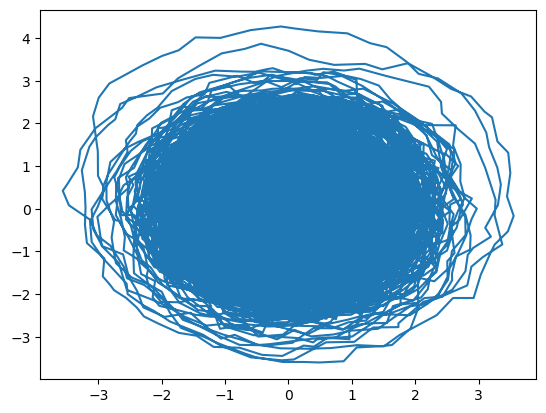

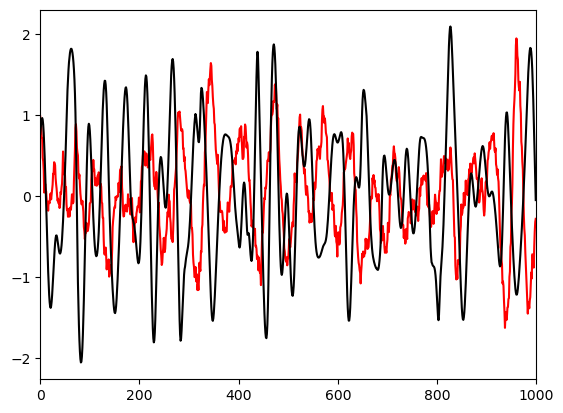

In [5]:
data    = np.load('LIM.npz')
rmm1_ML = data['rmm1_ML']
rmm2_ML = data['rmm2_ML']
det_LIM = data['det_LIM']
total_lag = 0

xi = zi       = np.arange(-2,2.01,0.01)
xi,zi         = np.meshgrid(xi,zi)
plt.figure()
plt.plot(rmm1_ML,rmm2_ML)

plt.figure()
plt.plot(rmm1_ML[0:1000],'r')
#plt.plot(rmm1_ML[0:2000],rmm2_ML[0:2000],'r')
plt.plot(rmm1[total_lag:1000],'k')
plt.xlim([0,1000])



## Estimating the smoothed determinant using Fourier transform in polar coordinate
### $\mathrm{det(G)} = \sum_{j=1}^{n} r_j \mathrm{e}^{i\theta}$ 
### $j=$circle index, $r=$ radius of $jth$ circle, $\theta=$ polar angle, 

In [7]:
from scipy.interpolate import griddata

# using Fourier transform instead 
r          = np.reshape(np.linspace(0, 3, 15, endpoint=True),[15,1])
degree     = np.reshape(np.linspace(0, 2*np.pi, 1000, endpoint=True),[1,1000])
x_ref      = np.matmul(r,np.cos(degree))
y_ref      = np.matmul(r,np.sin(degree))

det_polar  = griddata((xi.flatten(),zi.flatten()), (det_LIM[:,:,:].mean(axis=2)).flatten(), (x_ref.flatten(), y_ref.flatten()), method='nearest')
det_polar  = np.reshape(det_polar,[15,1000])

# define low passed filter 
def fourier(x, number_of_harmonics):
    x = np.squeeze(x)
    time_series = np.zeros((np.size(x),number_of_harmonics))
    for i in range(1,number_of_harmonics+1):
        time_series[:,i-1] = np.arange(0,np.size(x))/np.size(x)*2*i*3.14159
    cos_coef    = np.matmul(np.transpose(np.cos(time_series)),x)   
    sin_coef    = np.matmul(np.transpose(np.sin(time_series)),x)
    reconstruct = (np.matmul(np.cos(time_series),cos_coef)+np.matmul(np.sin(time_series),sin_coef))/np.size(x)  
    return reconstruct

# calculating Fourier transform for the ith circle 
for i in range(15):
    det_polar[i,:] = fourier(det_polar[i,:],2)



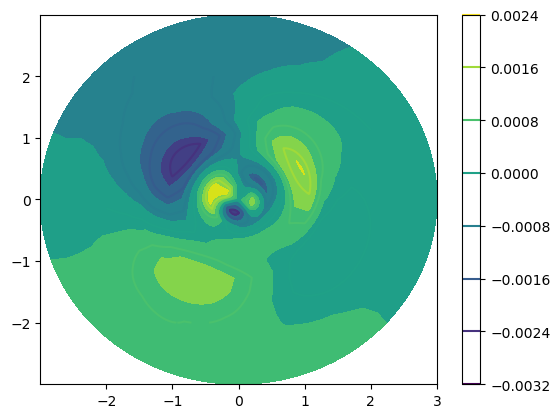

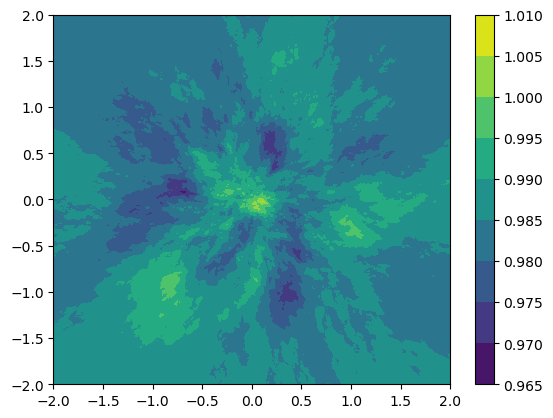

In [8]:
### convert polar coordinate back to Cartisien coordinate 

det_grid  = griddata((x_ref.flatten(),y_ref.flatten(),), (det_polar).flatten(), (xi,zi), method='linear')
det_grid  = griddata((x_ref.flatten(),y_ref.flatten(),), (det_polar).flatten(), (xi,zi), method='linear')
plt.figure()
cs=plt.contourf(x_ref,y_ref,det_polar+det_LIM.mean(axis=(0,1,2,)))
cs=plt.contour(xi,zi,det_grid)
plt.colorbar(cs)
plt.figure()
cs=plt.contourf(xi,zi,det_LIM.mean(axis=(2,)))
plt.colorbar(cs)

In [30]:
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
# Step 1: 
# assign initial PDF to data point
x_coordinate = 0
y_coordinate = -0.5
var          = multivariate_normal(mean=[x_coordinate,y_coordinate], cov=[[0.1,0],[0,0.1]])
rho_zero     = np.zeros(np.shape(rmm1_ML))

for i in range(np.size(rmm1_ML)):
    rho_zero[i] = var.pdf([rmm1_ML[i],rmm2_ML[i]])

# Step 2:
# creating checker 
xi = zi       = np.arange(-2.0,2.01,0.01)
xi,zi         = np.meshgrid(xi,zi)

# meshgrid to Cartesian coordinate 
# meshgrid back to grid_wise 
# these two steps help remove wiggle pattern 

# then integrate forward in time! 
t_total       = 47
rho           = np.zeros((np.size(rmm1_ML[:-t_total,]),t_total))
rho[:,0]      = rho_zero[:-t_total,]

for t in range(t_total-1):
    if t>0:
        rho_tmp         = griddata((rmm1_ML[t:-t_total+t],rmm2_ML[t:-t_total+t]),rho[:,t],(xi,zi),method='linear')
        rho_tmp         = gaussian_filter(rho_tmp, sigma=20)
        rho[:,t]        = griddata((xi.flatten(),zi.flatten()), rho_tmp.flatten(), (rmm1_ML[t:-t_total+t], rmm2_ML[t:-t_total+t]), method='nearest')
    det               = griddata((xi.flatten(),zi.flatten()), (det_LIM.mean(axis=(2,))).flatten(), (rmm1_ML[t:-t_total+t], rmm2_ML[t:-t_total+t]), method='nearest')
    det_SINDy         = griddata((x_ref.flatten(),y_ref.flatten()), det_polar.flatten(), (rmm1_ML[t:-t_total+t], rmm1_ML[t:-t_total+t]), method='nearest')
    #rho[:,t+1]        = rho[:,t]*(1-det_SINDy)
    rho[:,t+1]        = rho[:,t]/(det)
    rho[:,t+1]        = rho[:,t+1]/np.nansum(rho[:,t+1])



In [22]:
# calculating 95% confidence interval 

def find_CI(rho):
    global CI_95,CI_66, posi
    for i in range(100):
        value_1     = np.percentile(rho/np.sum(rho),100-i-1)
        value_2     = np.percentile(rho/np.sum(rho),100-i)
        posi_1      = np.where((rho/np.sum(rho))>value_1)
        posi_2      = np.where((rho/np.sum(rho))>value_2)
        threshold_1 = np.sum((rho/np.sum(rho))[posi_1])
        threshold_2 = np.sum((rho/np.sum(rho))[posi_2])
        if (threshold_1-0.95)*(threshold_2-0.95)<0:
            posi    = posi_2
            indices = np.random.choice(range(len(posi_2[0])), replace=False, size=30)
            posi    = np.array(posi_2[0])[indices.astype(int)]
            CI_95   = value_2
        elif  (threshold_1-0.66)*(threshold_2-0.66)<0:
            posi    = posi_2
            indices = np.random.choice(range(len(posi_2[0])), replace=False, size=30)
            CI_66   = value_2
    return CI_95, CI_66, posi


0
18
0
13
0
13
1
13
2
14
2
12
2
13
4
12
4
14
3
13
3
12
3
12
3
12
2
12
2
12
1
11
1
11
0
8
0
9
0
11
1
12
1
14
2
15
2
18
2
18
2
18
2
17
2
17
5
16
5
14
5
12
5
12
4
13
6
12
6
13
6
13
6
13
6
13
6
14
6
15


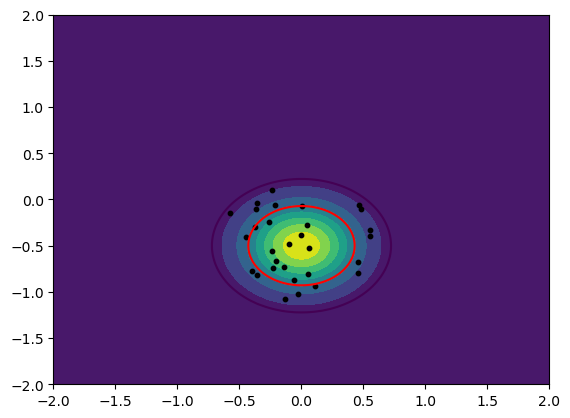

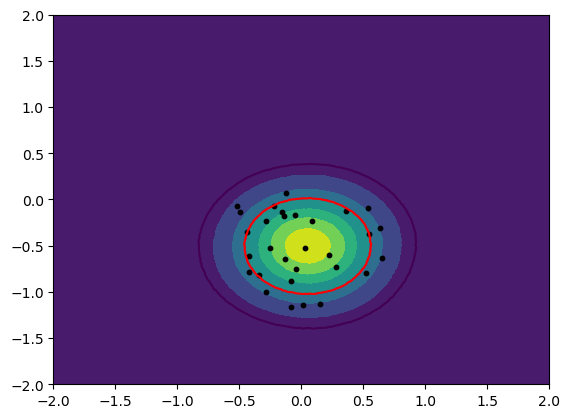

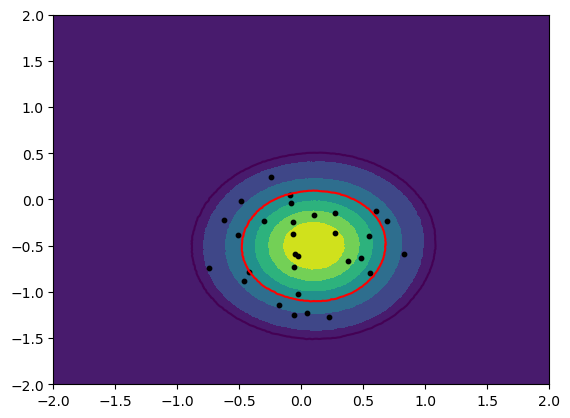

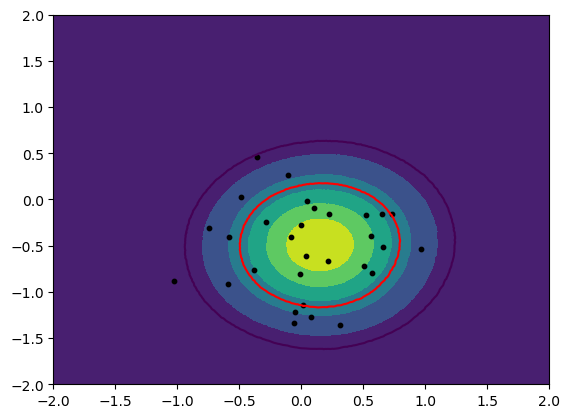

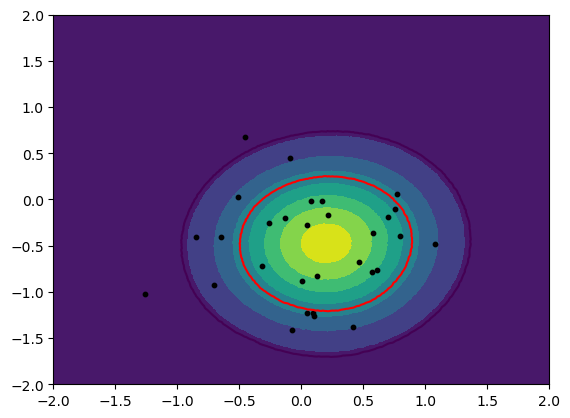

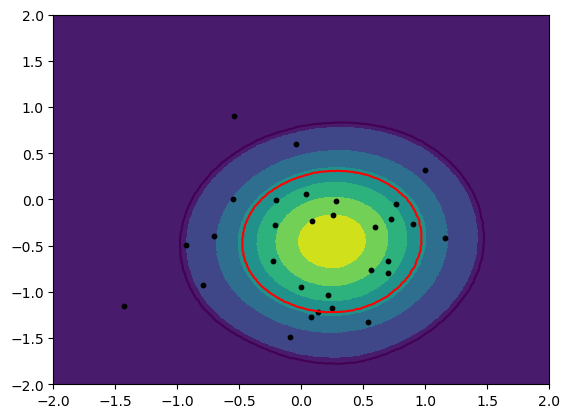

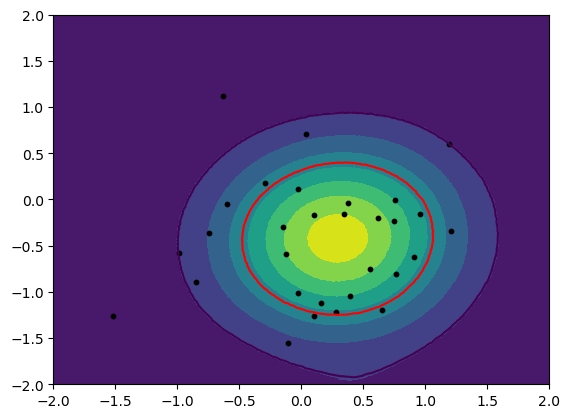

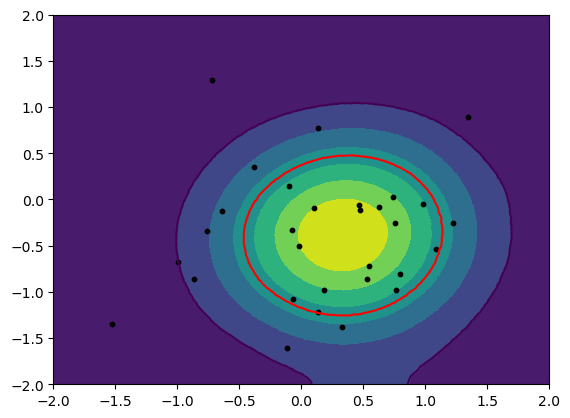

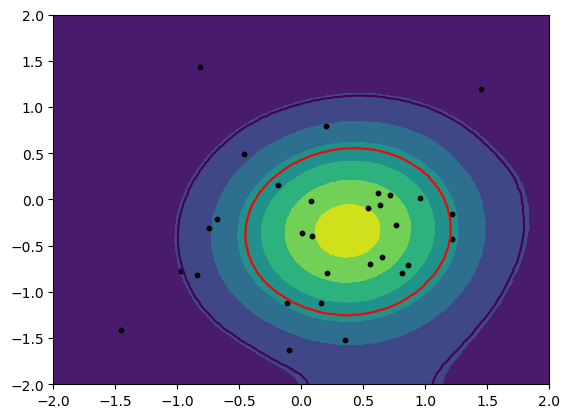

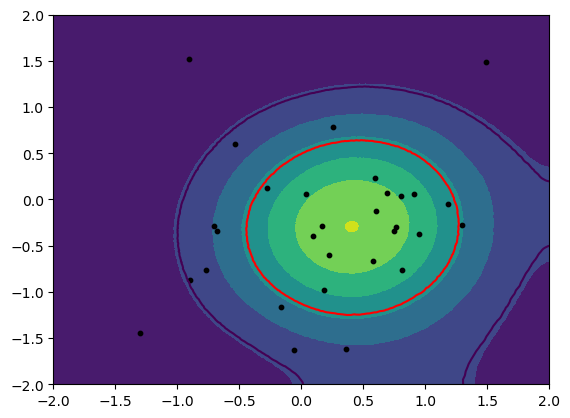

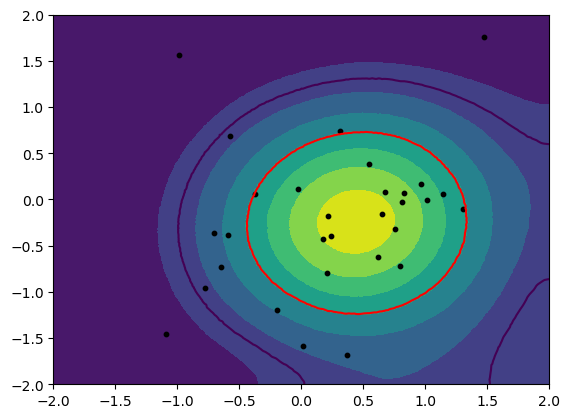

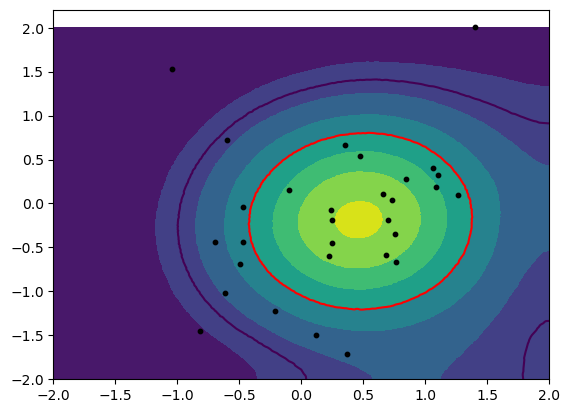

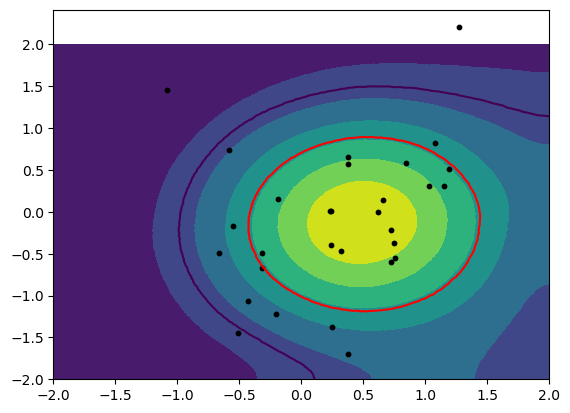

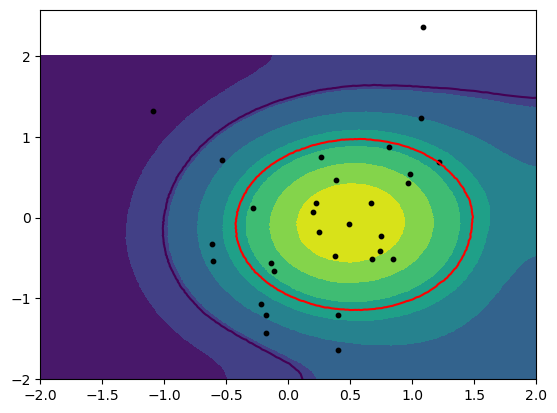

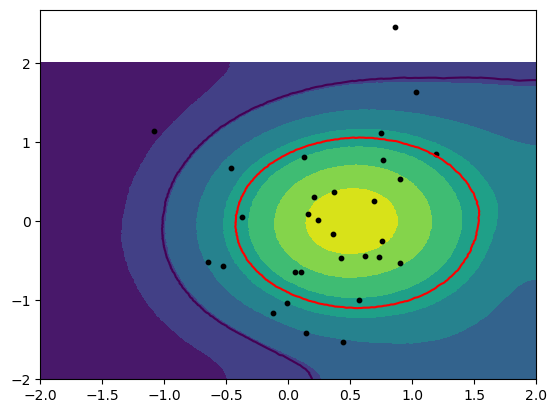

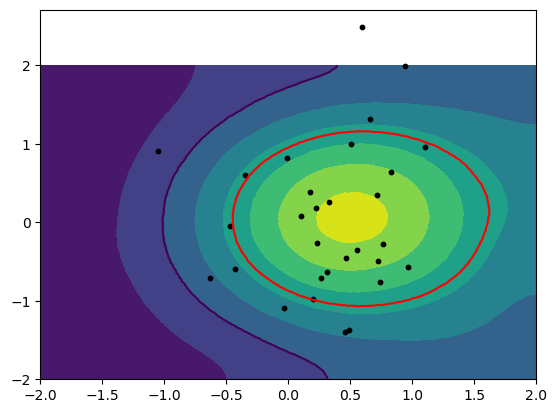

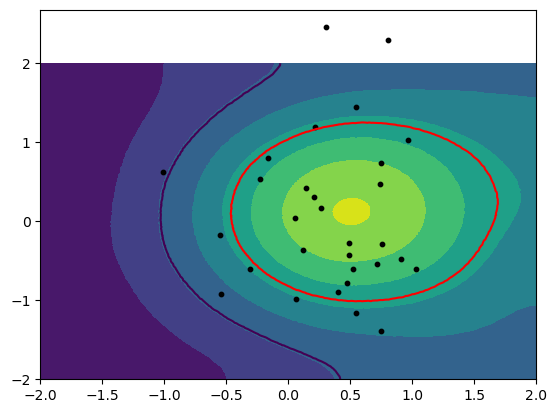

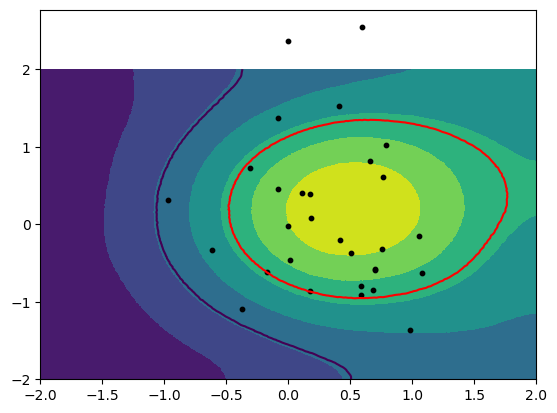

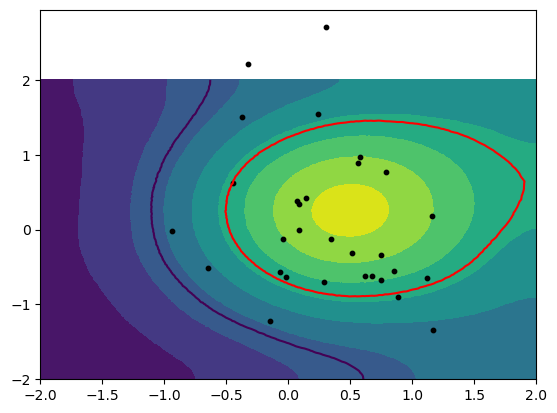

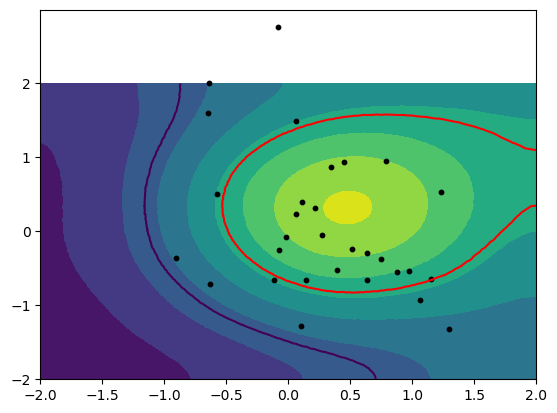

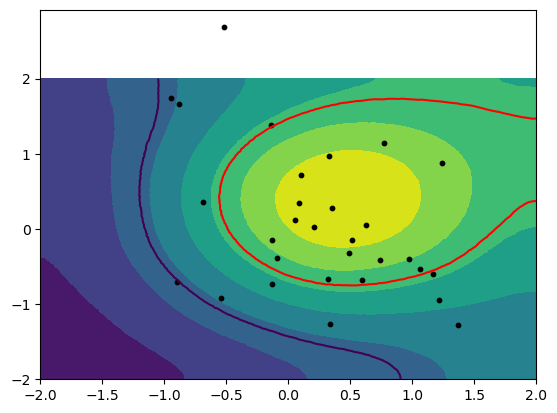

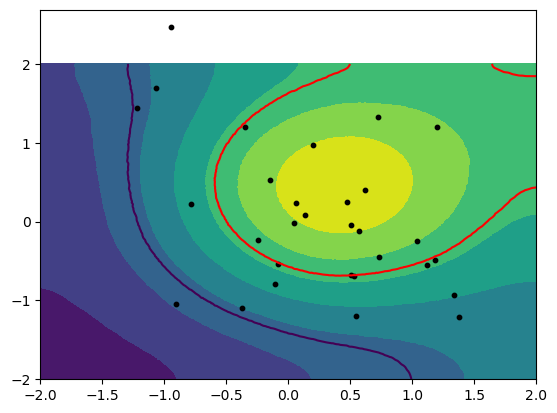

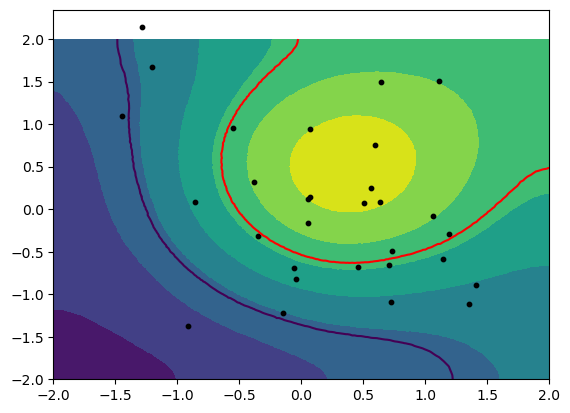

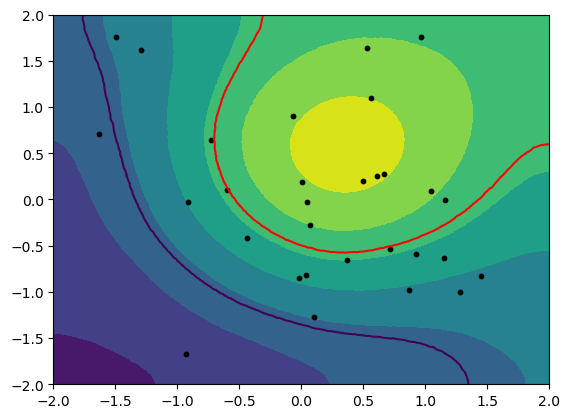

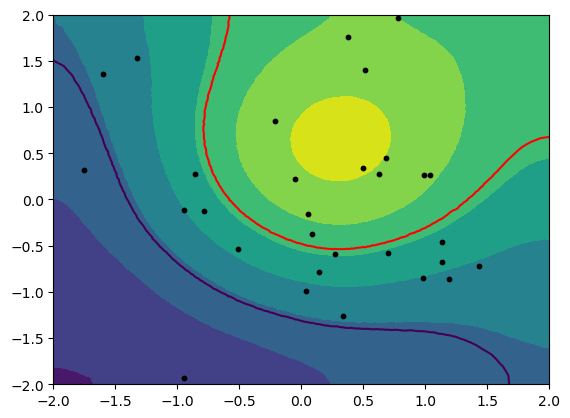

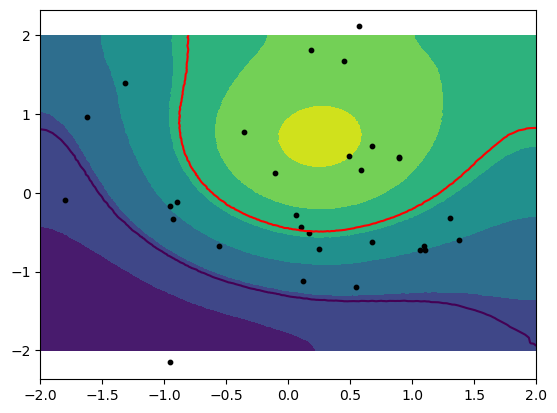

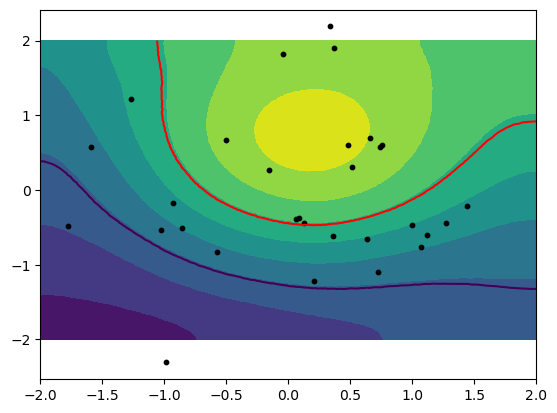

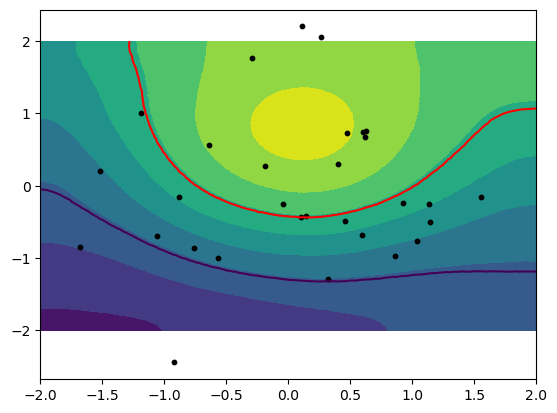

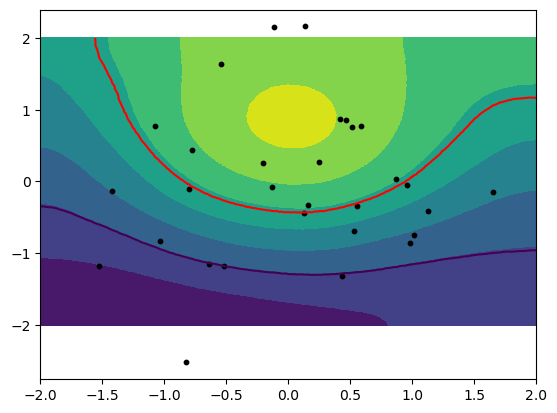

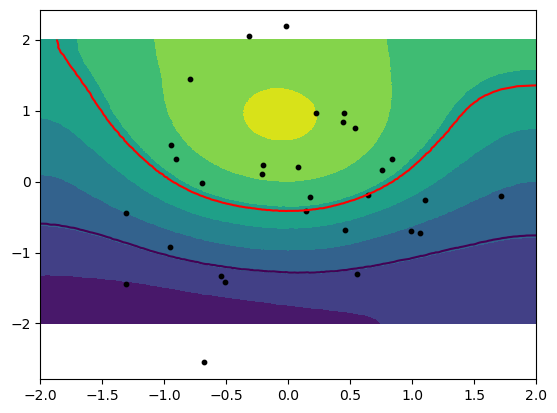

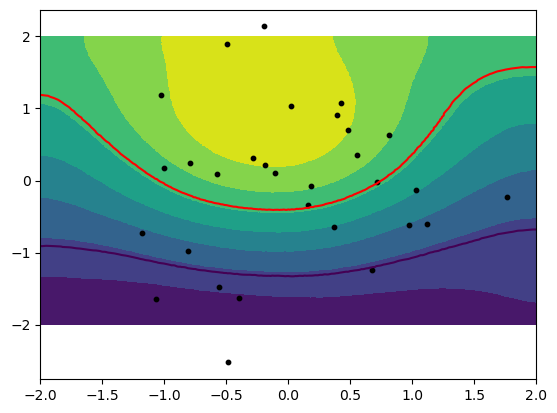

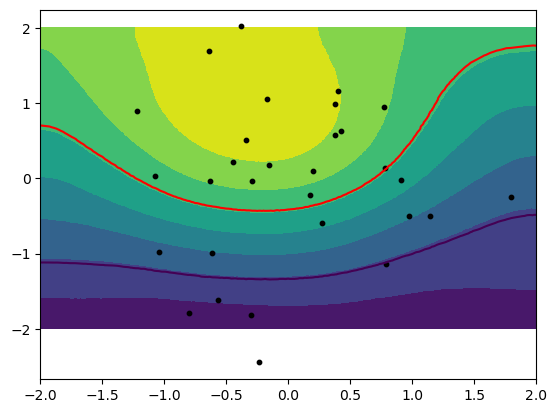

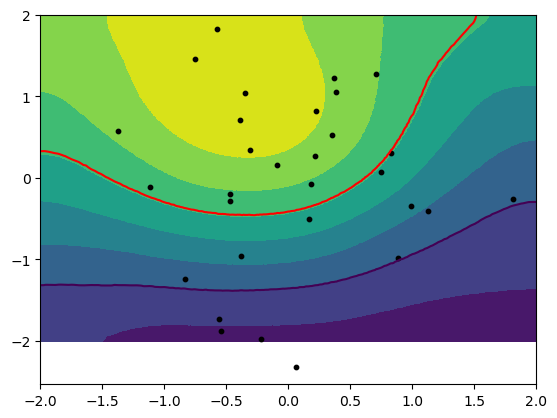

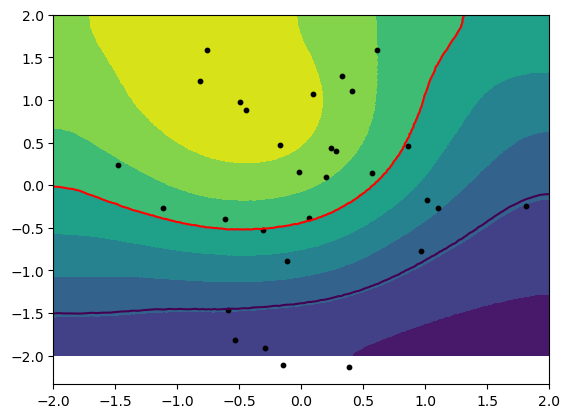

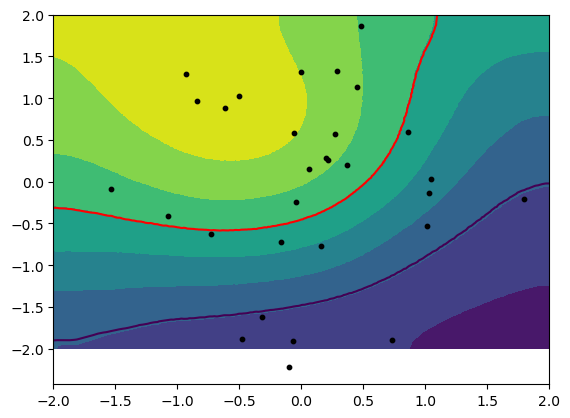

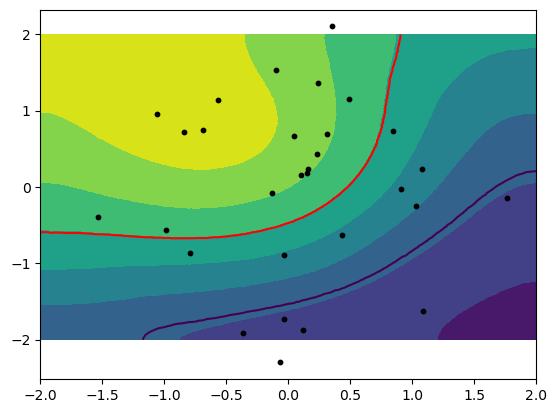

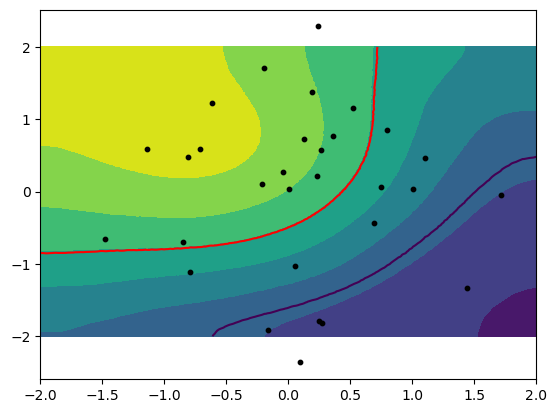

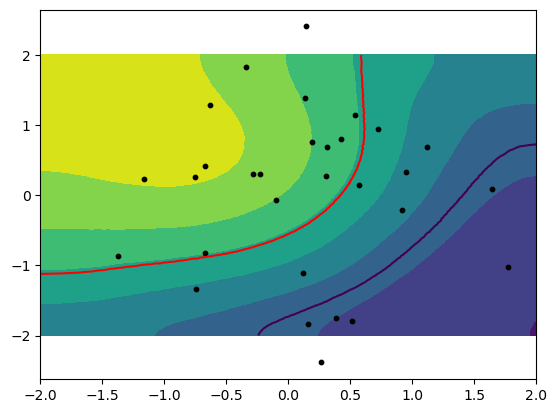

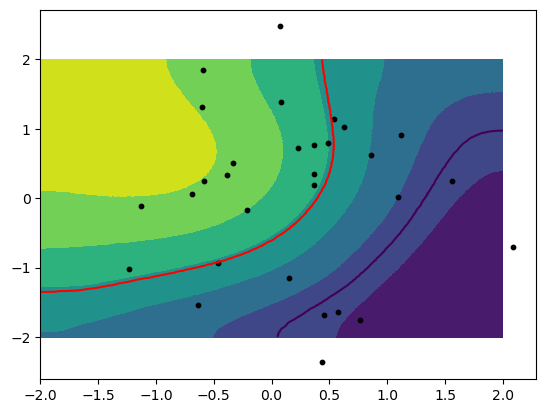

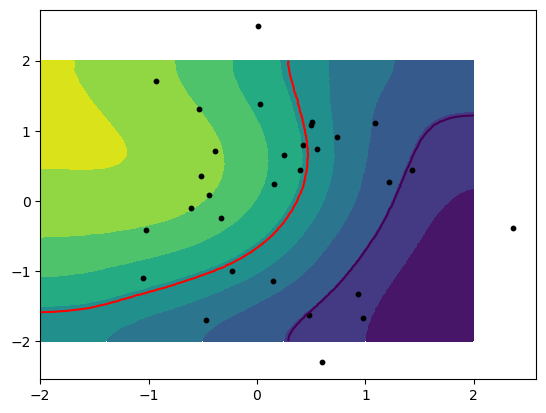

In [43]:
# make 500 times of reforecast 


for t in range(0,40,1):
    # model forecast
    rho_tmp = griddata((rmm1_ML[t:-t_total+t],rmm2_ML[t:-t_total+t]),rho[:,t]/np.nansum(rho[:,t]),(xi,zi),method='linear')
    plt.figure()
    plt.contourf(xi,zi,rho_tmp)
    CI_95,CI_66,posi_95 = find_CI(rho[:,t])
    plt.contour(xi,zi,rho_tmp,levels=[CI_95])
    plt.contour(xi,zi,rho_tmp,levels=[CI_66],colors='r')

    # verification
    # if today the observation is independent of the forecast above 
    # we can first select some random points falling within the CI

    # choose 30 data points at t = 0
    if t==0:
        # print(t)
        rho_obs_grid          = griddata((xi.flatten(),zi.flatten()),(rho_tmp).flatten(),(rmm1[t:-t_total+t],rmm2[t:-t_total+t]),method='linear')
        rho_obs_Cartesian     = griddata((rmm1[t:-t_total+t], rmm2[t:-t_total+t]), rho_obs_grid,(xi,zi),method='nearest')
        time_range            = np.arange(np.size(rho_obs_grid))
        posi_2                = np.where((rho_obs_grid>CI_95) & (time_range<13514-47))
        indices               = np.random.choice(range(len(posi_2[0])), replace=False, size=30)
        posi_95_obs           = np.array(posi_2[0])[indices.astype(int)]
        # CI_95_obs,posi_95_obs = find_CI(rho_obs_grid)
        # print(posi_95_obs)
    
    plt.scatter((rmm1[t:-t_total+t])[posi_95_obs],(rmm2[t:-t_total+t])[posi_95_obs],s=10,color='k')
    
    # calculate the data point falling outside CI at each step 
    # step 1: find the location
    data_point            = (rmm1[t:-t_total+t])[posi_95_obs],(rmm2[t:-t_total+t])[posi_95_obs]
    # step 2: find 95% CI
    CI_95_obs,CI_66_obs,posi_95_    = find_CI(rho[:,t])
    # step 3: map the forecast rho back to 30 data points and see if they are standing on rho smaller than 95% CI
    point_wise_rho        = griddata((xi.flatten(),zi.flatten()),(rho_tmp).flatten(),data_point,method='nearest')
    # count how many points fall outside CI
    print(np.size(np.where(point_wise_rho<CI_95)))
    print(np.size(np.where(point_wise_rho<CI_66)))